# 2. Korean TrOCR Training
---

## Introduction
--- 
훈련 데이터가 준비되었으면, 허깅페이스의 `VisionEncoderDecoderModel` 클래스로 TrOCR 모델을 쉽게 훈련할 수 있습니다. 이 클래스는 이미지 트랜스포머 기반 인코더(예: ViT, DeiT)와 텍스트 트랜스포머 기반 (예: BERT, RoBERTa) 디코더를 결합한 인코더-디코더 아키텍처를 가지고 있으며, 마이크로소프트에서 영어 이미지 데이터로 사전 훈련된 TrOCR 모델을 공개하였습니다.

하지만, 한국어 이미지 데이터의 경우는 영문 TrOCR 모델로 미세 조정을 수행하는 것보다 한국어 사전 훈련된 RoBERTa 모델을 초기 가중치로 사용하는 것이 좀 더 유리합니다. 
본 핸즈온에서는 앞 모듈에서 준비한 한국어 이미지 데이터로 저자가 사전에 훈련한 모델로 가볍게 미세 조정을 수행하고 추론 결과를 확인합니다. 

만약 전체 데이터셋으로 진행하고 싶다면 첫 번째 코드 셀에서 `FULL_TRAINING = True`로 변경한 후 실행해 주세요. 전체 데이터셋으로 진행하는 경우, 훈련에 매우 오랜 시간이 소요되므로, 분산 훈련을 권장합니다.
SageMaker로 진행하는 경우 `ml.g4dn.12xlarge`나 `ml.g5.12xlarge`를 권장합니다.

**[Note] SageMaker Studio Lab, SageMaker Studio, SageMaker 노트북 인스턴스, 또는 여러분의 로컬 머신에서 이 데모를 실행할 수 있습니다. SageMaker Studio Lab을 사용하는 경우 GPU를 활성화하세요.**


### Referencs
- TrOCR GirHub: https://github.com/microsoft/unilm/tree/master/trocr
- Hugging Face TrOCR Tutorial: https://huggingface.co/docs/transformers/model_doc/trocr
- Hugging Face Stage-1 pre-trained model: https://huggingface.co/microsoft/trocr-base-stage1

In [1]:
FULL_TRAINING = False

import numpy as np
import pandas as pd
from pynvml import *
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import VisionEncoderDecoderModel, AutoTokenizer

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()
    

df = pd.read_csv('labels.txt', header=None, sep="^(\d+\.jpg)", engine='python')
df = df.drop(df.columns[[0]], axis=1)
df.rename(columns={1: "file_name", 2: "text"}, inplace=True)
df['text'] = df['text'].str.strip()

# Just for hands-on lab
if not FULL_TRAINING:
    df = df.sample(n=100, random_state=42)

In [2]:
if FULL_TRAINING:
    vision_hf_model = 'facebook/deit-base-distilled-patch16-384'
    nlp_hf_model = "klue/roberta-base"
    
    # Reference: https://github.com/huggingface/transformers/issues/15823
    # initialize the encoder from a pretrained ViT and the decoder from a pretrained BERT model. 
    # Note that the cross-attention layers will be randomly initialized, and need to be fine-tuned on a downstream dataset
    model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(vision_hf_model, nlp_hf_model)
    tokenizer = AutoTokenizer.from_pretrained(nlp_hf_model)
else:
    trocr_model = 'daekeun-ml/ko-trocr-base-nsmc-news-chatbot'
    model = VisionEncoderDecoderModel.from_pretrained(trocr_model)
    tokenizer = AutoTokenizer.from_pretrained(trocr_model)     

In [3]:
# tokenized_input_for_pytorch = tokenizer("대 분 눈동자 자부심 풍속 조기 오르내리다 중국어 대비 운전", return_tensors="pt")

# print("Tokens (str)      : {}".format([tokenizer.convert_ids_to_tokens(s) for s in tokenized_input_for_pytorch['input_ids'].tolist()[0]]))
# print("Tokens (int)      : {}".format(tokenized_input_for_pytorch['input_ids'].tolist()[0]))
# print("Tokens (attn_mask): {}\n".format(tokenized_input_for_pytorch['attention_mask'].tolist()[0]))

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

`TrOCRProcessor`를 사용하여 모델의 데이터를 준비합니다. `TrOCRProcessor`는 `ViTFeatureExtractor`(이미지 크기를 조정하고 정규화하는 데 사용) 및 `RobertaTokenizer`(input_ids에서 텍스트를 인코딩 및 디코딩하는 데 사용할 수 있음)를 둘러싼 래퍼 클래스입니다.

데이터셋의 레코드는 픽셀값과 정답 텍스트(주어진 이미를 설명하는 텍스트를 토큰화한 input_id)을 리턴합니다.

In [5]:
class OCRDataset(Dataset):
    def __init__(self, dataset_dir, df, processor, tokenizer, max_target_length=32):
        self.dataset_dir = dataset_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.dataset_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text      
        labels = self.tokenizer(text, padding="max_length", 
                                stride=32,
                                truncation=True,
                                max_length=self.max_target_length).input_ids
        
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [6]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
dataset_dir = './dataset/'
max_length = 64

train_dataset = OCRDataset(
    dataset_dir=dataset_dir,
    df=train_df,
    tokenizer=tokenizer,
    processor=processor,
    max_target_length=max_length
)
eval_dataset = OCRDataset(
    dataset_dir=dataset_dir,
    df=test_df,
    tokenizer=tokenizer,
    processor=processor,
    max_target_length=max_length
)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 90
Number of validation examples: 10


pixel_values torch.Size([3, 384, 384])
labels torch.Size([64])


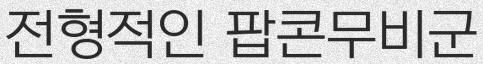

In [7]:
img_idx = np.random.randint(len(train_df))
encoding = train_dataset[img_idx]
for k,v in encoding.items():
    print(k, v.shape)
    
image = Image.open(train_dataset.dataset_dir + train_df['file_name'][img_idx]).convert("RGB")
image    

In [8]:
labels = encoding['labels']
labels[labels == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(labels, skip_special_tokens=True)
print(label_str)

전형적인 팝콘무비군


<br>

## Training

여기에서 사전 훈련된 가중치에서 TrOCR 모델을 초기화합니다. 모델이 사전 훈련 단계에서 텍스트를 생성하도록 이미 훈련되었기 때문에 언어 모델링 헤드의 가중치는 사전 훈련에서 이미 초기화되었습니다. 자세한 내용은 논문을 참조하십시오.

- 레이블에서 decoder_input_ids를 생성하는 데 필요한 속성(모델은 레이블을 오른쪽으로 한 위치 이동하고 decoder_start_token_id 앞에 추가하고 -100인 id를 pad_token_id로 교체하여 decoder_input_ids를 자동으로 생성합니다)
- 모델의 어휘 크기(디코더 상단의 언어 모델링 헤드용)
- 텍스트를 생성할 때 사용되는 beam-search 관련 매개변수.


Importantly, we need to set a couple of attributes, namely:

- the attributes required for creating the decoder_input_ids from the labels (the model will automatically create the decoder_input_ids by shifting the labels one position to the right and prepending the decoder_start_token_id, as well as replacing ids which are -100 by the pad_token_id)
- the vocabulary size of the model (for the language modeling head on top of the decoder)
- beam-search related parameters which are used when generating text.

In [9]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = max_length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [10]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    fp16=True,
    learning_rate=4e-5,
    output_dir="./",
    logging_dir="./logs",
    logging_steps=10,
    save_steps=5000,
    eval_steps=5000,
)

문자 오류율(CER; Character Error Rate)과 단어 오류율(WER; Word Error Rate) 지표로 모델을 평가합니다.

In [11]:
import evaluate
cer_metric = evaluate.load("cer")

In [ ]:
# predictions = ["this is the prediction", "there is an other sample"]
# references = ["this is the reference", "there is another sample"]
# metrics = evaluate.load("cer", "wer")
# metrics.compute(predictions=predictions, references=references)

In [ ]:
# def compute_metrics(pred):
#     labels_ids = pred.label_ids
#     pred_ids = pred.predictions

#     pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
#     labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
#     label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

#     f1 = f1_metric.compute(predictions=pred_ids, references=labels_ids)
#     cer = cer_metric.compute(predictions=pred_str, references=label_str)

#     return {"f1": f1, "cer": cer}

In [12]:
wer_metric = evaluate.load("wer")

In [13]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}

In [14]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

Using cuda_amp half precision backend


In [15]:
print_gpu_utilization()

GPU memory occupied: 2519 MB.


In [16]:
result = trainer.train()

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 90
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 1
  Number of trainable parameters = 225701120
/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




In [17]:
if FULL_TRAINING:
    steps = []
    losses = []
    for obj in trainer.state.log_history:
        steps.append(obj['step'])
        losses.append(obj['loss'])

    import matplotlib.pyplot as plt
    f = plt.figure(figsize=(12,6))
    plt.plot(steps, losses)
    plt.xlabel('step')
    plt.ylabel('training loss')
    plt.show()    

In [18]:
trainer.save_model(output_dir="./model")

Saving model checkpoint to ./model
Configuration saved in ./model/config.json
Model weights saved in ./model/pytorch_model.bin
tokenizer config file saved in ./model/tokenizer_config.json
Special tokens file saved in ./model/special_tokens_map.json


<br>

## Evaluation and Inference
---


In [19]:
model.eval()
with torch.no_grad():
    eval_result = trainer.evaluate(eval_dataset, max_length=64)    

***** Running Evaluation *****
  Num examples = 10
  Batch size = 128


In [20]:
eval_result

{'eval_loss': 0.6399032473564148,
 'eval_cer': 0.05113636363636364,
 'eval_wer': 0.09523809523809523,
 'eval_runtime': 1.9185,
 'eval_samples_per_second': 5.212,
 'eval_steps_per_second': 0.521,
 'epoch': 1.0}

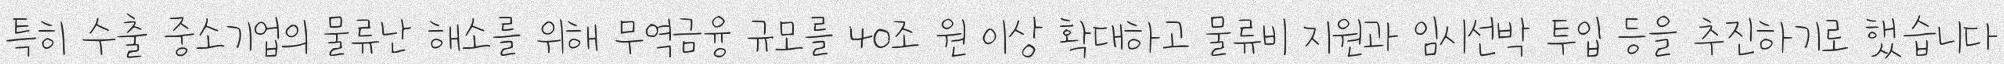

In [23]:
import glob
sample_img_paths = glob.glob('sample_imgs/*.jpg')
img_idx = np.random.randint(len(sample_img_paths))
image = Image.open(sample_img_paths[img_idx])
#img_idx = np.random.randint(len(eval_dataset))
#image = Image.open(eval_dataset.dataset_dir + train_df['file_name'][img_idx])
image

In [24]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
device = torch.device('cuda')

pixel_values = (processor(image, return_tensors="pt").pixel_values).to(device)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0] 
generated_ids, generated_text

(tensor([[    0,     0,  3727,  4264,  4722,  2079,  6921,  2336,  5343,  2138,
           3627,  4902, 14554,  3849,  2138,  4064,  2446,  1478,  3658,  3989,
          19521,  6921,  2151,  3691,  2151,  3691,  2145,  5937,  2020,  2042,
           5113,   886,  2069,  3835, 31302,  2200,  1902,  2219,  3606,     2]],
        device='cuda:0'),
 '특히 수출 중소기업의 물류난 해소를 위해 무역금융 규모를 40조 원 이상 확대하고 물류비 지원비 지원과 임시선박 투입 등을 추진하기로 했습니다')

<br>

## Clean up
---


In [27]:
!rm -rf model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## (Optional) Upload to Hugging Face Hub

In [28]:
# !pip install huggingface_hub

In [29]:
# from huggingface_hub import notebook_login
# notebook_login()

In [30]:
# # repo
# MODEL_SAVE_REPO = '[YOUR-REPO]'
# HUGGINGFACE_AUTH_TOKEN = '[YOUR-TOKEN]' # https://huggingface.co/settings/token

# # Push to huggingface-hub
# model.push_to_hub(
#     MODEL_SAVE_REPO,
#     use_temp_dir=True,
#     use_auth_token=HUGGINGFACE_AUTH_TOKEN
# )

# tokenizer.push_to_hub(
#     MODEL_SAVE_REPO,
#     use_temp_dir=True,
#     use_auth_token=HUGGINGFACE_AUTH_TOKEN
# )